<a href="https://colab.research.google.com/github/amkatrutsa/edm/blob/master/MultiMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Code source: https://github.com/intel-isl/MultiObjectiveOptimization/tree/master/multi_task

# Dataset loader

These are random examples from MultiMNIST dataset. Type 'ex' to stop loader


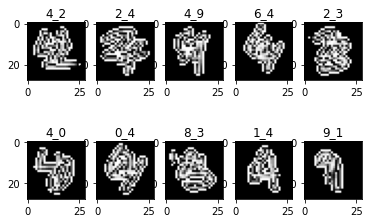

ex


In [6]:
from __future__ import print_function
import torch.utils.data as data
from PIL import Image
import os
import os.path
import errno
import numpy as np
import torch
import codecs
import scipy.misc as m


class MNIST(data.Dataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'training.pt'
    test_file = 'test.pt'
    multi_training_file = 'multi_training.pt'
    multi_test_file = 'multi_test.pt'

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, multi=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.multi = multi

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if not self._check_multi_exists():
            raise RuntimeError('Multi Task extension not found.' +
                               ' You can use download=True to download it')


        if multi:
            if self.train:
                self.train_data, self.train_labels_l, self.train_labels_r = torch.load(
                    os.path.join(self.root, self.processed_folder, self.multi_training_file))
            else:
                self.test_data, self.test_labels_l, self.test_labels_r = torch.load(
                    os.path.join(self.root, self.processed_folder, self.multi_test_file))
        else:
            if self.train:
                self.train_data, self.train_labels = torch.load(
                    os.path.join(self.root, self.processed_folder, self.training_file))
            else:
                self.test_data, self.test_labels = torch.load(
                    os.path.join(self.root, self.processed_folder, self.test_file))


    def __getitem__(self, index):
        import matplotlib.pyplot as plt
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.multi:
            if self.train:
                img, target_l, target_r = self.train_data[index], self.train_labels_l[index], self.train_labels_r[index]
            else:
                img, target_l, target_r = self.test_data[index], self.test_labels_l[index], self.test_labels_r[index]
        else:
            if self.train:
                img, target = self.train_data[index], self.train_labels[index]
            else:
                img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy().astype(np.uint8), mode='L')
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        if self.multi:
            return img, target_l, target_r
        else:
            return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))
    
    def _check_multi_exists(self):
        return  os.path.exists(os.path.join(self.root, self.processed_folder, self.multi_training_file)) and \
            os.path.exists(os.path.join(self.root, self.processed_folder, self.multi_test_file))

    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""
        from six.moves import urllib
        import gzip

        if self._check_exists() and self._check_multi_exists():
            return

        # download files
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        for url in self.urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.root, self.raw_folder, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            with open(file_path.replace('.gz', ''), 'wb') as out_f, \
                    gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print('Processing...')
        mnist_ims, multi_mnist_ims, extension = read_image_file(os.path.join(self.root, self.raw_folder, 'train-images-idx3-ubyte'))
        mnist_labels, multi_mnist_labels_l, multi_mnist_labels_r = read_label_file(os.path.join(self.root, self.raw_folder, 'train-labels-idx1-ubyte'), extension)

        tmnist_ims, tmulti_mnist_ims, textension = read_image_file(os.path.join(self.root, self.raw_folder, 't10k-images-idx3-ubyte'))
        tmnist_labels, tmulti_mnist_labels_l, tmulti_mnist_labels_r = read_label_file(os.path.join(self.root, self.raw_folder, 't10k-labels-idx1-ubyte'), textension)


        mnist_training_set = (mnist_ims, mnist_labels)
        multi_mnist_training_set = (multi_mnist_ims, multi_mnist_labels_l, multi_mnist_labels_r)

        mnist_test_set = (tmnist_ims, tmnist_labels)
        multi_mnist_test_set = (tmulti_mnist_ims, tmulti_mnist_labels_l, tmulti_mnist_labels_r)

        with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
            torch.save(mnist_training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
            torch.save(mnist_test_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.multi_training_file), 'wb') as f:
            torch.save(multi_mnist_training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.multi_test_file), 'wb') as f:
            torch.save(multi_mnist_test_set, f)
        print('Done!')

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)


def read_label_file(path, extension):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
        multi_labels_l = np.zeros((1*length),dtype=np.long)
        multi_labels_r = np.zeros((1*length),dtype=np.long)
        for im_id in range(length):
            for rim in range(1):
                multi_labels_l[1*im_id+rim] = parsed[im_id]
                multi_labels_r[1*im_id+rim] = parsed[extension[1*im_id+rim]] 
        return torch.from_numpy(parsed).view(length).long(), torch.from_numpy(multi_labels_l).view(length*1).long(), torch.from_numpy(multi_labels_r).view(length*1).long()


def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
        pv = parsed.reshape(length, num_rows, num_cols)
        multi_length = length * 1
        multi_data = np.zeros((1*length, num_rows, num_cols))
        extension = np.zeros(1*length, dtype=np.int32)
        for left in range(length):
            chosen_ones = np.random.permutation(length)[:1]
            extension[left*1:(left+1)*1] = chosen_ones
            for j, right in enumerate(chosen_ones):
                lim = pv[left,:,:]
                rim = pv[right,:,:]
                new_im = np.zeros((36,36))
                new_im[0:28,0:28] = lim
                new_im[6:34,6:34] = rim
                new_im[6:28,6:28] = np.maximum(lim[6:28,6:28], rim[0:22,0:22])
                multi_data_im = np.array(Image.fromarray(new_im).resize((28, 28))) 
                multi_data[left*1 + j,:,:] = multi_data_im
        return torch.from_numpy(parsed).view(length, num_rows, num_cols), torch.from_numpy(multi_data).view(length,num_rows, num_cols), extension

if __name__ == '__main__':
    import torch
    import torchvision
    import matplotlib.pyplot as plt
    from torchvision import transforms
    import matplotlib.pyplot as plt

    def global_transformer():
        return transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))])

    dst = MNIST(root='./data/MultiMNIST/', train=True, download=True, transform=global_transformer(), multi=True)
    loader = torch.utils.data.DataLoader(dst, batch_size=10, shuffle=True, num_workers=4)
    for dat in loader:
        print('These are random examples from MultiMNIST dataset. Type \'ex\' to stop loader')
        ims = dat[0].view(10,28,28).numpy()

        labs_l = dat[1]
        labs_r = dat[2]
        f, axarr = plt.subplots(2,5)
        for j in range(5):
            for i in range(2):
                axarr[i][j].imshow(ims[j*2+i,:,:], cmap='gray')
                axarr[i][j].set_title('{}_{}'.format(labs_l[j*2+i],labs_r[j*2+i]))
        plt.show()
        a = input()
        if a == 'ex':
            break
        else:
            plt.close()
